### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

You can add more imports if needed.

In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/DL Assignment 2/DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            # print(int(filename[:-4]))
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [5]:
img_array = np.array(images)

In [6]:
img_array.shape

(1238, 268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("/content/drive/MyDrive/DL Assignment 2/Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1254 rows matches the image data shape above

(1238, 6)

In [12]:
years = df4["Year"].values
titles = df4["Title"].values
assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [13]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"/content/drive/MyDrive/DL Assignment 2/DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [14]:
# Refrence- https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101
# Refrence- https://keras.io/guides/sequential_model/
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input

n_movies = img_array.shape[0]
embedding_size = 110592 # YOUR CODE HERE

X = tf.zeros((n_movies, embedding_size))

### YOUR CODE HERE
#Basemodel using Resnet50
basemodel= tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(268, 182, 3))
#Creating a sequentail model
my_model = keras.Sequential()
#Adding the basemodel to the sequentail model
my_model.add(basemodel)
#Adding a flatten layer
my_model.add(layers.Flatten())

#Preprocessing the images 
pre_process = tf.keras.applications.mobilenet.preprocess_input(img_array)

#Creating the embeddings of the preprocessed images
X=my_model.predict(pre_process)


assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

39/39 [==============================] - 4s 36ms/step


In [15]:
print(X.shape)

(1238, 110592)


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [16]:
def k_nearest(img, k):
    ### YOUR CODE HERE
    #Calculating euclidean_distances using cdist
    euclidean_distances= cdist(img,X,metric='euclidean')

    distances=[]
    # return K sorted euclidean_distances
    for i in euclidean_distances:
      #K+1 to ignore the original image
      distances.append(np.argsort(i)[:k+1])
    return distances

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


1/1 [==============================] - 0s 223ms/step


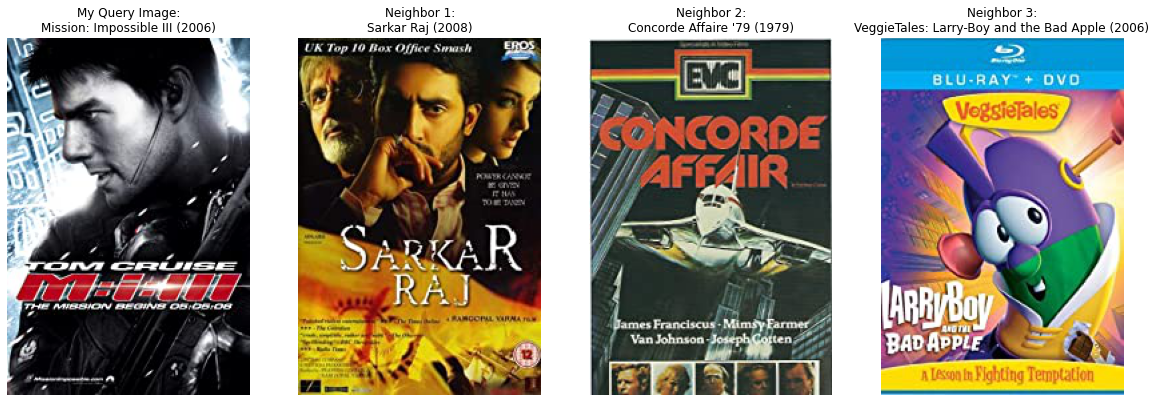

In [17]:
### YOUR CODE HERE
# My query poster- Mission: Impossible III (2006)
Q_idx = 317919 # YOUR VALUE HERE - DO NOT USE MY VALUE

# Number of nearest neighbors
k=3 

my_img_1 = imread(Q_idx) 
my_img_array = np.array(my_img_1)
my_img_array = np.expand_dims(my_img_array, axis=0) 
my_pre_img = tf.keras.applications.mobilenet.preprocess_input(my_img_array)

my_image_embedding= my_model.predict(my_pre_img)

my_sorted_index =k_nearest(my_image_embedding,k)
# print(my_sorted_index)
# x= df4.iloc[712]
# print(x.name)

#Plotting my image along with the nearest 3 neighbors
fig, ax = plt.subplots(1, 4,figsize=(20, 20))
c=0
nearest_titles=[]
for i in my_sorted_index[0]:
  a=df4.iloc[i]
  nearest_titles.append(a.Title)
  # imshow(imread(int(a.name)))
  if c==0:
    ax[c].imshow(imread(int(a.name)))
    ax[c].axis('off')
    ax[c].set_title("My Query Image:\n"+a.Title)
  else:
    ax[c].imshow(imread(int(a.name)))
    ax[c].axis('off')
    ax[c].set_title("Neighbor "+str(c)+":\n"+a.Title)
  c+=1

#Comments: 

**The neighbors are similar to the query poster in following ways:**
1.   The titles on the posters are in either in white or red
2.   The dominant background colors are dark grey/ black or blue
3.   Model recognise people's/animated cartoon's faces

**The neighbors are dissimilar to the query poster in following ways:**
1.   The neighbors have a dominant yellow/orange shade.
2.   Neighbor 1 and 2 have multiple people on the posters.
3.   Neighbor 3 has a animated cartoon instead of a person.

**Do you agree with the choice and the ranking?**
*   While the ranking is not accurate, it is not terrible either, I do not entirely agree with it.

**Why do you think they are close in the embedding?**
*   I think they are close in embeddings because of the similarities in them as mentioned above.

**Do you notice, for example, that the nearest neighbours are from a similar era?**
*   Two of the nearest neighbors (neighbor 1 and 3) are acutally very close to the query poster year. Neighbor 2 however, is an exception in this case.

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [18]:
### YOUR CODE HERE

from sklearn.model_selection import train_test_split
# Splitting the already preprocessed data in into train and test
X_train, X_test, y_train, y_test = train_test_split(pre_process, years, random_state=10, train_size = .70)

In [19]:
#Refrence- https://keras.io/api/metrics/
# Refrence- https://github.com/gabrielcassimiro17/object-detection/blob/main/transfer_learning.ipynb

from tensorflow.keras.callbacks import EarlyStopping

#creatibng additiional dense layer that will be added to above model
additional_layer1 = layers.Dense(1024, activation=None)
additional_layer2 = layers.Dense(256, activation=None)
additional_layer3 = layers.Dense(64, activation=None)

#Adding additional layers
my_model.add(additional_layer1)
my_model.add(additional_layer2)
my_model.add(additional_layer3)

#Compiling the model
my_model.compile(optimizer='adam', loss='mean_squared_error')

#Early stopping that will monitor val_loss and stop training if there is no significant improvement for 10 epochs
Early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

#Training the model that predicts the year
my_model.fit(x=X_train, y=y_train, batch_size=16, epochs=50,validation_split=0.2, callbacks=[Early_stopping],shuffle='False')

Epoch 1/50
44/44 [==============================] - 42s 157ms/step - loss: 366272.4688 - val_loss: 2299244.0000
Epoch 2/50
44/44 [==============================] - 4s 91ms/step - loss: 18711.8672 - val_loss: 655888.8125
Epoch 3/50
44/44 [==============================] - 4s 91ms/step - loss: 5699.2002 - val_loss: 487392.5000
Epoch 4/50
44/44 [==============================] - 4s 92ms/step - loss: 3689.5288 - val_loss: 246863.3750
Epoch 5/50
44/44 [==============================] - 4s 90ms/step - loss: 4043.3997 - val_loss: 89851.8281
Epoch 6/50
44/44 [==============================] - 4s 90ms/step - loss: 5366.3926 - val_loss: 27939.5176
Epoch 7/50
44/44 [==============================] - 4s 92ms/step - loss: 4260.5146 - val_loss: 8519.1240
Epoch 8/50
44/44 [==============================] - 3s 77ms/step - loss: 1491.7815 - val_loss: 9352.8135
Epoch 9/50
44/44 [==============================] - 4s 92ms/step - loss: 1268.7688 - val_loss: 7662.9497
Epoch 10/50
44/44 [====================

In [20]:
#Predicting the year based on the move posters
predictions= my_model.predict(X_test)

12/12 [==============================] - 2s 67ms/step


In [21]:
#Taking the mean of all the predictions to get a single prediction year
pred1= np.mean(predictions,axis=1)
# Rounding the predicted tyear value
pred2 = np.round(pred1)

In [32]:
#Comparing the predicted year with the original year

print("Prediction year",pred2[2])
print("Actual year",y_test[2])

Prediction year 2000.0
Actual year 2010.0


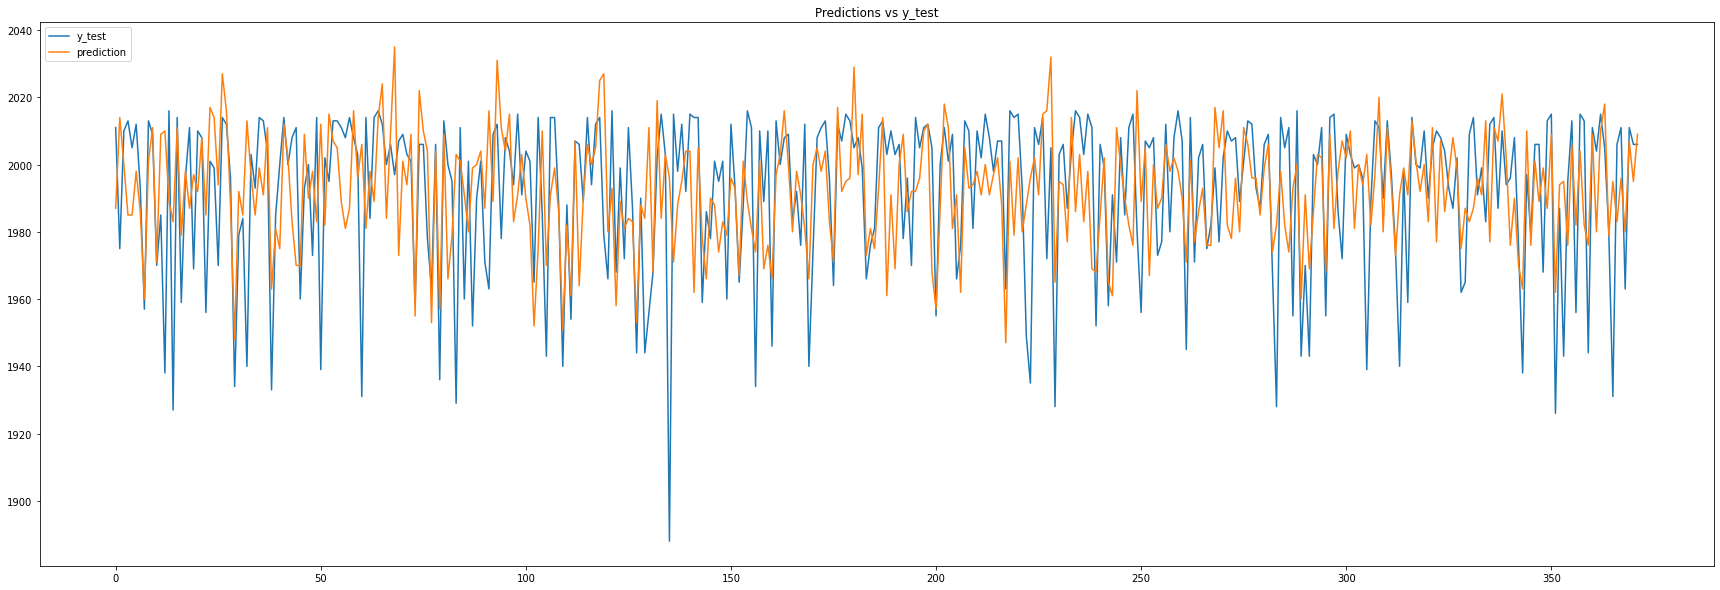

In [23]:
#Plotting prdiction vs y-test data
fig = plt.figure(figsize = (30,10))
fig = plt.plot(y_test)
fig = plt.plot(pred2)
plt.title('Predictions vs y_test')
plt.legend(['y_test', 'prediction'], loc='upper left')
plt.show()

Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

Yes, It is possible to predict the year. Based on my results, Some predictions were similar to the original year, while there were some predictions which were way too different.

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [24]:
#Refrence- https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

### YOUR CODE HERE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# First Model X contains the embeddings and y contains the corresponding labels
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

df_embedding = pd.DataFrame()

df_embedding['years'] = years
df_embedding['Titles'] = titles
df_embedding['x'] = X_tsne[:,0]

df_embedding['y'] = X_tsne[:,1]

# My Model predictions contains the embeddings and y_test contains the corresponding labels
my_X_tsne=tsne.fit_transform(predictions)

my_df_embedding = pd.DataFrame()

my_df_embedding['years'] = y_test
my_df_embedding['x'] = my_X_tsne[:,0]

my_df_embedding['y'] = my_X_tsne[:,1]

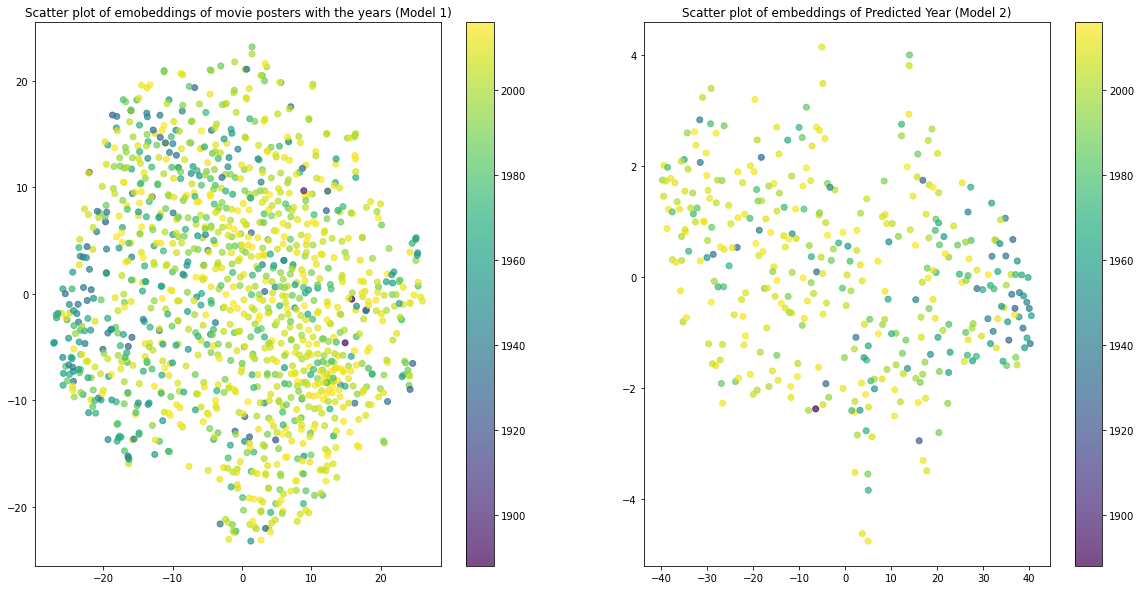

In [25]:
# Set figsize
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Scatter plot 1
scatter1 = axs[0].scatter(df_embedding.x, df_embedding.y, c=years, alpha=.7)
plt.colorbar(scatter1, ax=axs[0])
axs[0].set_title('Scatter plot of emobeddings of movie posters with the years (Model 1)')

# Scatter plot 2
scatter2 = axs[1].scatter(my_df_embedding.x, my_df_embedding.y, c=y_test, alpha=.7)
plt.colorbar(scatter2, ax=axs[1])
axs[1].set_title('Scatter plot of embeddings of Predicted Year (Model 2)')

plt.show()

The first plot above  shows embedding of all the posters created by model 1 and there corresponding years. While the second plot above shows the embeddings of the predicted year  along with the year.

In [26]:
matches_list=[]
for i in nearest_titles:
  match = df_embedding[df_embedding.Titles.str.contains(i, regex=False)]
  matches_list.append(match)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


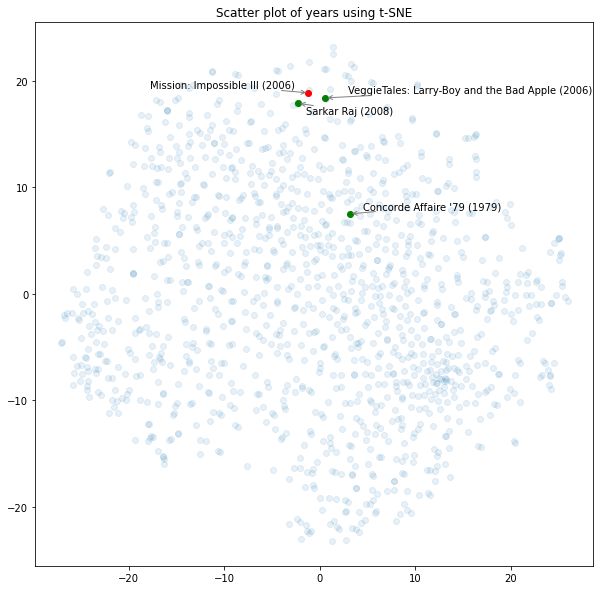

In [27]:
#Refrence- https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e?permalink_comment_id=3296622

!pip install adjustText
from adjustText import adjust_text

matches_list=[]
for i in nearest_titles:
    match = df_embedding[df_embedding.Titles.str.contains(i, regex=False)]
    matches_list.append(match)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_embedding.x, df_embedding.y, alpha=.1)
count=0
texts = []
for i in matches_list:
    if count==0:
        ax.scatter(i.x, i.y, color='red', alpha=1)
        texts += [plt.text(x0, y0, name, ha='center', va='center') for x0, y0, name in zip(i.x, i.y, i.Titles)]
        count+=1
    else:
        ax.scatter(i.x, i.y, color='green', alpha=1)
        texts += [plt.text(x0, y0, name, ha='center', va='center') for x0, y0, name in zip(i.x, i.y, i.Titles)]
    
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'), autoalign='xy', expand_points=(1.2, 1.5))
plt.title('Scatter plot of years using t-SNE')
plt.show()

The above plot shows the embedding of the query Image 'Mission: Impossible III (2006)' highlighted in "Red" and its nearest neighbors  'Sarkar Raj (2008)', "Concorde Affaire '79 (1979)" and 'VeggieTales: Larry-Boy and the Bad Apple (2006)' highlighted in green which enables us to visualize close the embedding really are. When I put the the embeddings with the year in TSNE, The second nearest neighbor which is from (1979) move far away from the other two nearest neighbors which are from the close years.